In [1]:
import numpy as np
import matplotlib.pyplot as plt

From Jessop 2018 Equation 17

$$A(r) = \frac{\mu}{4\pi} \int_{\Omega} \frac{J_c (r')}{|r-r'|} \,d\tau '$$




A is the magnetic vector potential at r

r is the position of the observation point P,

r' is the position of the integration point around the current source point M

$d\tau '$ denotes a volume element around the source M

$Curl(A)$ results in the Biot Savart Law being returned

Normal magnetic field:

$$ B_o (r) = \frac{\mu}{4\pi} \int J_s (r') \times \frac{r- r'}{|r-r'|^3}\,d\tau '$$

$J_s$ is the source current density inside the source region - NEED CLARIFICATION, 

Is this the vector from the EField?

See: Willowstick method

$J_s$ is defined as $\frac{A}{m^2}$

"The normal magnetic field at observation point r is given by the volume integral over the area around the source charge"

# Edwards 1974

Any component of the normal field due to a pair of electrodes can be obtaineed by the superposition of two solutions of the type,

$$H_t = \frac{I}{4 \pi r}$$



In [2]:
x = np.linspace(-10,10)
y = np.linspace(-10,10)
z = np.linspace(-10,10)
xx, yy = np.meshgrid(x,y)

In [3]:
def NField_x(x,y,L,I):
    """
    Gives the cross component of the normal field between two electrodes
    located at (0, L/2; z1) and at (0, -L/2; z2) where z1 and z2 are arbitrary 
    depths
    Implemented from equation 4.5 in Edwards 1974
    """
    a = (y/L + 0.5) / (np.power(x/L, 2) + (np.power(y/L + 0.5, 2))) 
    b = (y/L - 0.5) / (np.power(x/L, 2) + (np.power(y/L - 0.5, 2)))
    return I * (a - b) / 4 / np.pi / L

In [5]:
def NField_x_single(x,y,L,I):
    a = (y/L + 0.5) / (np.power(x/L, 2) + (np.power(y/L + 0.5, 2)))
    return I * a / 4 / np.pi / L

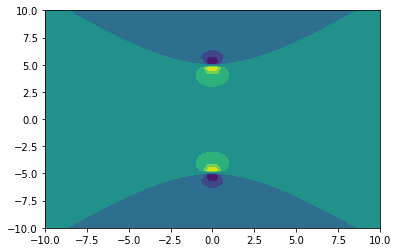

In [6]:
plt.contourf(xx, 
             yy, 
             NField_x(xx,yy,10,1))

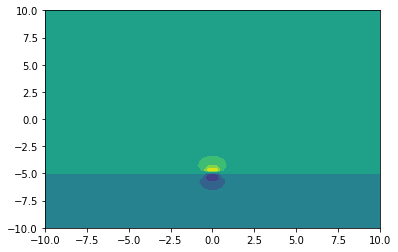

In [7]:
plt.contourf(xx, 
             yy, 
             NField_x_single(xx,yy,10,1))

# Veitch 1990
## Distributed B-Field in a Layered Earth
#### Similar to Edwards and Nabighian 1991

Layer coefficients are needed within the potential field integral

from Veitch 1990:
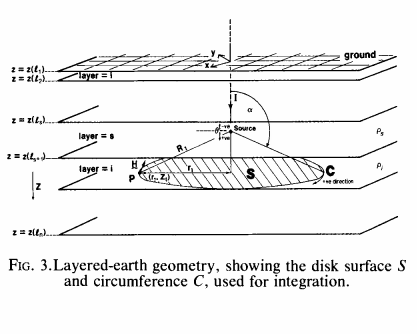

Electric potential (Voltage)
$$ U(r,z) = \frac{I \rho_s}{4\pi} \left\{ \frac{1}{R} + \int_{0}^{\infty} \left[\alpha_i(\lambda) e^{\lambda z} + \beta_i(\lambda) e^{\lambda z}\right] J_1(\lambda r)  d\lambda \right\}  $$ 

For $z \geq 0$: below the electrode, no wire through the surface of integration

$$ H(r,z) = \frac{I}{4\pi r} \left\{ r \frac{\rho_s}{\rho_p} \int_{0}^{\infty} \left[(\beta_i + 1) e^{-\lambda z} - \alpha_i e^{\lambda z}\right] J_1(\lambda r)  d\lambda - 1 + \frac{z}{R} \right\}  $$ 

For $z < 0$: above the source, wire passes through the surface of integration and flux from wire must be added

$$ H(r,z) = \frac{I}{4\pi r} \left\{ r \frac{\rho_s}{\rho_p} \int_{0}^{\infty} \left[\beta_i e^{-\lambda z} - (\alpha_i + 1) e^{\lambda z}\right] J_1(\lambda r)  d\lambda + 1 + \frac{z}{R} \right\} $$

Where $R = \sqrt{(r^2 + z^2)}$

For each lambda in the integrals, a separate $(\alpha_i, \beta_i)$ has to be calculated

To solve for $\alpha_i, \beta_i$:

For $z \geq 0$: Below the source
$$\alpha_i = A_i + \overline{A_i} \alpha_1$$

For $z < 0$: Above the source

$$\alpha_i = D_i + \overline{D_i} \beta_n$$ above the source (including the wire)